# Download data

# Kaggle Competition 

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import joblib

In [2]:
train_data = pd.read_parquet("data/train_data.parquet")

In [ ]:
train_data.shape

(29220048, 101)

## Data cleaning

In [4]:
# feature selection ## select every feature except 0-4 
feature_cols = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
# feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

In [5]:
from sklearn.preprocessing import MinMaxScaler

# ScaleX = MinMaxScaler(feature_range=(-1,1))
# ScaleX.fit(train_data[feature_cols])
# joblib.dump(ScaleX, "model/ScaleX.pkl")
# ScaleY = MinMaxScaler(feature_range=(-1,1))
# ScaleY.fit(train_data[target_cols])
# joblib.dump(ScaleY, "model/ScaleY.pkl")

# ScaleX =    joblib.load("model/ScaleX.pkl")
# ScaleY =    joblib.load("model/ScaleY.pkl")

In [6]:
# the chunk requir maximum memory
# X_train =   ScaleX.transform(train_data[feature_cols])
# y_train =   ScaleY.transform(train_data[target_cols])
# w_train =   train_data[weight_cols]

X_train =   train_data[feature_cols]
y_train =   train_data[target_cols]
w_train =   train_data[weight_cols]
del train_data #save ram it screaming for help right now

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [8]:
# state the search
# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5, 6, 7, 8 , 9, 10, 11],
#     'n_estimators': [100, 200, 300, 500, 1000],
#     'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
#     'reg_lambda': [0, 0.01, 0.1, 1, 10, 100],
#     'min_child_weight': [1, 3, 5, 7],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
# }

# #define the model
# model  = XGBRegressor(random_state = 42 , device = 'cuda')

# # define grid_search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='r2', verbose=1, n_jobs=-1, random_state=42)

# # do the grid search
# random_search.fit(X_train_sampled, y_train_sampled, sample_weight = w_train_sampled)

# # Get the best parameters and evaluate the model
# best_params = random_search.best_params_
# print(f"Best parameters found: {best_params}")

In [9]:
best_params = {'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': 'cuda',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': 3,
#  'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


NameError: name 'nan' is not defined

In [42]:
# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**best_params)

# Fit the model to the training data
model.fit(X_train, y_train, sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
val_data =  pd.read_parquet("data/validate_data.parquet")
# X_val =     ScaleX.transform(val_data[feature_cols])    
X_val =     val_data[feature_cols]  
y_val =     val_data[target_cols]
w_val =     val_data[weight_cols]

In [44]:
pred = model.predict(X_val)
# pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(y_val, pred, sample_weight=w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.007871


In [45]:
pred.min(), pred.max()

(-1.7476209, 4.4357266)

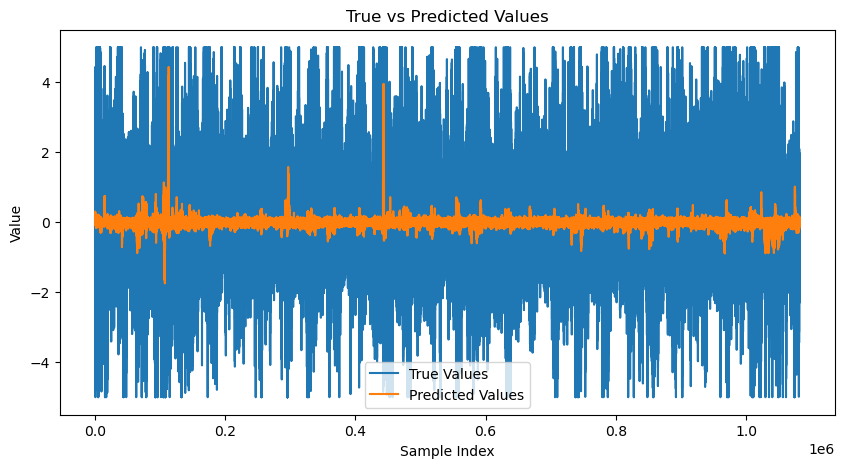

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [47]:
def validate_n_fold(model,X_val, y_val,w_val, n_folds):
    global ScaleY
    batch_size = len(y_val)//n_folds    
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i+batch_size]
        y_batch = y_val[i:i+batch_size]
        w_batch = w_val[i:i+batch_size]
        preds = model.predict(X_batch)
        # preds = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(y_batch, preds ,sample_weight= w_batch)
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [48]:
validate_n_fold(model,X_val, y_val, w_val, 10)

Batch 0 r2_score: 0.006316
Batch 1 r2_score: 0.012686
Batch 2 r2_score: 0.005828
Batch 3 r2_score: 0.003788
Batch 4 r2_score: 0.015663
Batch 5 r2_score: 0.007376
Batch 6 r2_score: 0.007817
Batch 7 r2_score: 0.004908
Batch 8 r2_score: 0.006882
Batch 9 r2_score: 0.005699
Batch 10 r2_score: -2.933841


# save data

In [49]:
import joblib
# save
joblib.dump(model, "model/XGBoost_ver4.4.pkl") 

['model/XGBoost_ver4.3.pkl']